# <center> *mocalum* tutorial 1 <br><br> Getting started with mocalum <center>

<img align="right" src="assets/workflow.png">
A notebook by Nikola Vasiljević
    
 ## Introduction
 This is an interactive tutorial that will introduce you to the basic of Monte Carlo uncertainty modeling using `mocalum` package. After completing the tutorial you will be familiar with basic `mocalum` functionality such as:
  - Adding lidars to the `mocalum` object
  - Configuring lidar measurement scenario
  - Configuring and generating lidar uncertainty contributors
  - Configuring and generating flow field
  - Calculating radial velocity
  - Reconstructing wind speed
  - Accessing generated `mocalum` specific `xarray` datasets
    
    
## On *mocalum*
    
`mocalum` is a python package for Monte Carlo based lidar uncertainty modeling. It has following features:
 - Slick and super fast Monte Carlo uncertainty modeling (thouhsands of simulations in matter of seconds)
 - Simulation of single or multi lidar configuration
 - Configuration of arbitrary trajectories for single and multi lidars
 - Configuration of `IVAP` (sector-scan) trajectory for single lidar
 - 3D or 4D / uniform or turbulent flow field generation
 - Sampling of correlated or uncorrelated uncertainty terms
 - Built-in 2nd order kinematic model for calculation of trajectory timing
 - 3D or 4D interpolation/projection of flow on lidar(s) line-of-sight(s)
 - Results given as [xarray](http://xarray.pydata.org/en/stable/#) datasets enriched with metadata (no more confusion what is what)

## *mocalum* workflow    
Typical `mocalum` workflow includes following steps (depict in the figure on right):
 1. Create mocalum object   
 1. Adding lidar(s) and configuring uncertainty contributors to the object
 2. Setting up measurement scenario for previously added lidar(s)
 3. Generating flow field entailing measurement points
 4. Project flow field on line-of-sight(s)
 5. Reconstruct wind vector(s)
 6. Perform statistical analysis of reconstructed wind vectors

We will follow the above workflow in this tutorial.
    
## Import packages
We will import standard and external packages that we will need in tutorial, specifically:
 - `numpy` is python's main numerical array package https://www.numpy.org/ 
 - `matplotlib` is python's main plotting package https://matplotlib.org/
 - `xarray` is a powerful high level package for labelled multi-dimensional arrays http://xarray.pydata.org
 - `mocalum`
 - `mocalum_tutorial` contains a plotting function that we will use in this tutorial
    

> **tutorial note**: some basic understanding of `xarray` is prerequisit to follow this tutorial. Therefore, get familiar with `xarray` first, particularly accessing and working with [dataset](http://xarray.pydata.org/en/stable/data-structures.html#dataset)
    

In [1]:
import numpy as np           
import matplotlib.pyplot as plt
import xarray as xr

import mocalum as mc

from mocalum_tutorial import plot_sd_scan_setup, plot_bbox

## Create and explore mocalum object

`mocalum` is developed considering object-oriented paradigm. Therefore, all calculations and access to generated data are through an instance of `mocalum` object on which various methods are applied. Once an instance of `mocalum` object is created users have access to following methods:

- `add_lidar`
- `generate_complex_trajectory`
- `generate_PPI_scan`
- `generate_uncertainties`
- `generate_flow_field`
- `project_to_los`
- `reconstruct_wind`

as well to `data` that will be created as a result of applying the above listed methods.

> **notebook note**: you can view the documentation for a function in jupyter notebooks by placing a `?` in front of the function, and you can get the entire function by using `??`.

In [2]:
mc_test = mc.Mocalum()

## Adding lidar and configuring uncertanty

Checking `docstring` of `add_lidar` method we can see that following parameters should be provided:
- `id` of lidar
- `lidar position` as `numpy` array of triplets (x, y, z)
- `uncertanty dictionary` containing configuration of uncertainty contributors

Lets consider a lidar which we will call 'koshava', located at position of (0,0,0) having following values for uncertainty contributors (standard uncertainty):
- estimation uncertainty of radial velocity of 0.1 m/s 
- ranging uncertainty of 5 m
- azimuth uncertainty of 0.1 deg
- elevation uncertainty of 0.1 deg
We will consider that uncertainty values are not correlated from one measurement point to another, thus correlation coeficient will be equal to 0

Accordingly we add the above lidar to the `mocalum` object `mc_test`:

In [3]:
lidar_pos = np.array([0,0,0])

unc_cfg = {'unc_az'   : 0.1,
           'unc_el'   : 0.1,
           'unc_rng'  : 5,
           'unc_est'  : 0.1,
           'corr_coef':0}

mc_test.add_lidar('koshava', lidar_pos, unc_cfg)

The lidar information are added to the measurement configuration dictionary stored inside `data` subobject:

In [4]:
mc_test.data.meas_cfg['koshava']

{'position': array([0, 0, 0]),
 'uncertainty': {'unc_az': {'mu': 0, 'std': 0.1, 'units': 'deg'},
  'unc_el': {'mu': 0, 'std': 0.1, 'units': 'deg'},
  'unc_rng': {'mu': 0, 'std': 5, 'units': 'm'},
  'unc_est': {'mu': 0, 'std': 0.1, 'units': 'm.s^-1'},
  'corr_coef': 0},
 'config': {}}

## Setting up measurement scenario for previously added lidar

Following the lidar placement and uncertainty configuration we will configure the measurement scenario which lidar will 'virtually' perform. In this example we will configure a `PPI` scan, thus we will use the built-in method `generate_PPI_scan`, which requires following inputs:
 - lidar id for which the PPI scan is configured
 - PPI scan dictionary containing following required parameters:
    - `sector_size` : size of the scanned sector in degrees
    - `azimuth_mid` : central azimuth angle of the PPI scanned arc
    - `angular_step` : Incremental step performed to complete a PPI scan
    - `acq_time` : acquisition time to complete an angular step, thus acquire LOS measurements
    - `elevation` : elevation angle of PPI scan
    - `range` : range at which measurements should take place
    - `no_scans` : number of PPI scans must be equal or bigger than 1
    
   while following parameters are optional: 
    - `max_speed` : maximum permitted angular speed
    - `max_acc` : maximum permitted angular acceleration
    

> **mocalum note**: your PPI dict keys must have names identical to names listed above. 

> **mocalum note**: If `max_speed` or `max_acc` are not provided `mocalum` considers that there are no kinematic restrictions, thus values for these parameters are consider to be infinit. This practically means that in case of a PPI scan the time it takes to return from the end of the PPI scan to its begining is 0 s. 

Let say we want to peform PPI scan of 30 deg centered at azimuth angle of 90 deg at range of 1 km over 100 m above ground level. We will do 10000 PPI scans and we will consider kinematic limits of the long-range WindScanner:

In [5]:
PPI_cfg = {
    'no_scans' : 10000,
    'range' : 1000,
    'meas_height' : 100,
    'elevation' : np.degrees(np.arcsin(100 / 1000)), # to assure measurements at 100 m agl
    'angular_step' : 1,  # degreee
    'acq_time' : 1,      # s
    'azimuth_mid' : 90,  # central azimuth angle
    'sector_size' : 30,  # degree
}

mc_test.generate_PPI_scan('koshava', PPI_cfg)

Now if we again inspeact measurement configuration dictionary for `koshava` we will notice that it became updated with PPI scan configuration:

In [6]:
mc_test.data.meas_cfg['koshava']

{'position': array([0, 0, 0]),
 'uncertainty': {'unc_az': {'mu': 0, 'std': 0.1, 'units': 'deg'},
  'unc_el': {'mu': 0, 'std': 0.1, 'units': 'deg'},
  'unc_rng': {'mu': 0, 'std': 5, 'units': 'm'},
  'unc_est': {'mu': 0, 'std': 0.1, 'units': 'm.s^-1'},
  'corr_coef': 0},
 'config': {'scan_type': 'PPI',
  'max_scn_speed': 50,
  'max_scn_acc': 100,
  'scn_speed': 1.0,
  'no_los': 30,
  'no_scans': 10000,
  'sectrsz': 30,
  'scn_tm': 30.0,
  'rtn_tm': 0,
  'az': array([ 75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,
          86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,
          97.,  98.,  99., 100., 101., 102., 103., 104.]),
  'el': array([5.73917048, 5.73917048, 5.73917048, 5.73917048, 5.73917048,
         5.73917048, 5.73917048, 5.73917048, 5.73917048, 5.73917048,
         5.73917048, 5.73917048, 5.73917048, 5.73917048, 5.73917048,
         5.73917048, 5.73917048, 5.73917048, 5.73917048, 5.73917048,
         5.73917048, 5.73917048, 5.73917048, 5.73

Besides the update of the measurement configuration dictionary, a probing `xarray` dataset was created in this step in the background which fused all information together. To access it we simply execture following command:

In [7]:
mc_test.data.probing['koshava']

<xarray.Dataset>
Dimensions:      (time: 300000)
Coordinates:
  * time         (time) float64 1.0 2.0 3.0 4.0 5.0 ... 3e+05 3e+05 3e+05 3e+05
Data variables:
    az           (time) float64 75.0 76.0 77.0 78.0 ... 101.0 102.0 103.0 104.0
    el           (time) float64 5.739 5.739 5.739 5.739 ... 5.739 5.739 5.739
    rng          (time) float64 1e+03 1e+03 1e+03 1e+03 ... 1e+03 1e+03 1e+03
    x            (time) float64 961.1 965.4 969.5 973.2 ... 973.2 969.5 965.4
    y            (time) float64 257.5 240.7 223.8 206.9 ... -206.9 -223.8 -240.7
    z            (time) float64 100.0 100.0 100.0 100.0 ... 100.0 100.0 100.0
    unc_az       (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    unc_el       (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    unc_rng      (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    unc_est      (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    sectrsz      int64 30
    no_scans     int64 10000
    no_los       int64 30
    scan_tm      float64 30.0
    return_tm    int64 0
    lidar_pos_x  int64 0
    lidar_pos_y  int64 0
    lidar_pos_z  int64 0
Attributes:
    title:    Lidar atmosphere probing dataset

For convinience a plotting function `plot_sd_scan_setup` has been implemented in `mocalum_tutorial` that helps visually representing the configure measurement scenario:

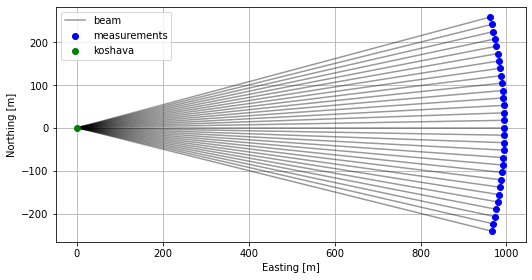

In [9]:
plot_sd_scan_setup('koshava', mc_test)

If we closely inspect the above dataset we will notice that all our uncertainty variables have value equal to 0. The reason for this is that we still did not sample uncertainty contributors. In fact we only setup expected standard deviation for each uncertainty contributor. To actually sample uncertainties we need to execute the method `generate_uncertainties`, which only requires lidar id as a parameter. We will call this method and then once again access the probing dataset to verify that it became updated with uncertainty values:

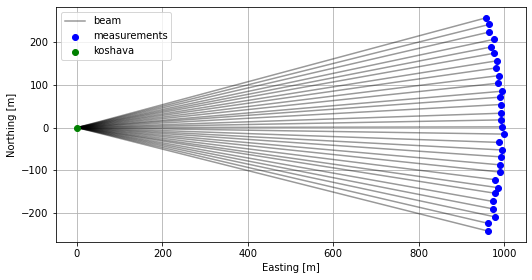

In [10]:
mc_test.generate_uncertainties('koshava')
mc_test.data.probing['koshava']

plot_sd_scan_setup('koshava', mc_test)

Now as we can see that even the plot measurement scenario changed, since we introduced uncertainty in laser beam pointing and ranging. If we execute command `mc_test.data.probing['koshava'].unc_el.std()` we will get exactly the value we set initial (in this case 0.1):

In [11]:
mc_test.data.probing['koshava'].unc_el.std()

<xarray.DataArray 'unc_el' ()>
array(0.09975264)

In [12]:
mc_test.data.bbox_meas_pts['koshava']

{'CRS': {'x': 'Absolute coordinate, coresponds to Easting in m',
  'y': 'Absolute coordinate, coresponds to Northing in m',
  'z': 'Absolute coordinate, coresponds to height above sea level in m',
  'rot_matrix': array([[ 1.,  0.],
         [-0.,  1.]])},
 'x': {'min': 919.716533514109,
  'max': 1041.2105665089118,
  'offset': 0,
  'res': 25},
 'y': {'min': -272.96204896640086,
  'max': 290.80086853302356,
  'offset': 0,
  'res': 25},
 'z': {'min': 86.87615383993575,
  'max': 112.70650866760047,
  'offset': 0,
  'res': 5},
 't': {'min': 1.0, 'max': 300000.0, 'offset': 0, 'res': 1.0}}

## Generating flow field entailing measurement points

Currently, `mocalum`, through the method `generate_flow_field`, provides means to generate:
- `uniform` flow field assuming that wind is only changing with height according to the [power law](https://en.wikipedia.org/wiki/Wind_profile_power_law)
- `turbulent` flow field which is generated using a wrapper around [pyconturb](https://gitlab.windenergy.dtu.dk/pyconturb/pyconturb)

Based on the measurement scenario `mocalum` calculates necessary dimensions and resolution of flow field box (3D for uniform or 4D for turbulent), generates the flow field data and saves them as `xarray` dataset. For this tutorial we will generate `uniform` flow field. The method `generate_flow_field` requires following input parameters:

 - `lidar_id` : string or list of string corresponding to lidar ids
 - `atmo_cfg` : dictionary describing mean flow parameters, containing following keys:
     - `wind_speed` : mean horizontal wind speed in m/s
     - `upward_velocity` : vertical wind speed in m/s
     - `wind_from_direction` : mean wind direction in deg
     - `reference_height` : height at which wind speed is given in m
     - `shear_exponent` : vertical wind shear exponent 
     
 - `flow_type` : flow field type to be generated, it can be `uniform` or `turbulent`

Let's define and generate flow field for 'koshava', which will be stored under `data.ffield`:

In [13]:
atmo_cfg={'wind_speed':5,
          'upward_velocity':0,
          'wind_from_direction':45,
          'reference_height':100, # we set the reference height same as the scanned height 
          'shear_exponent':0.2}

mc_test.generate_flow_field('koshava', atmo_cfg, 'uniform')


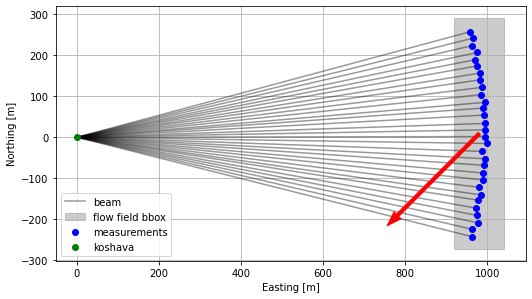

In [14]:
plot_bbox(mc_test)

We can plot flow field directly:

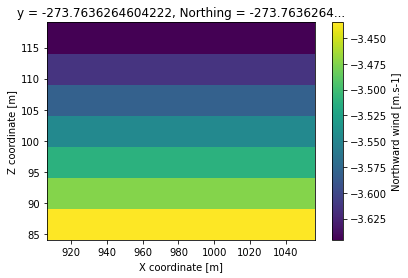

In [12]:
mc_test.data.ffield.isel(y=0).v.plot()

# Project flow field on line-of-sight(s)

Now we have all elements to calculate what wind lidar would measure, thus to project the flow field on the lidar LOSs. We do this using method `project_to_los`, which we supply with id of the lidar. This results in creation of yet another `xarray` dataset stored under `data.los['lidar_is']`.

In [16]:
mc_test.project_to_los('koshava')
mc_test.data.los['koshava']

<xarray.Dataset>
Dimensions:   (time: 300000)
Coordinates:
  * time      (time) float64 1.0 2.0 3.0 4.0 5.0 ... 3e+05 3e+05 3e+05 3e+05
Data variables:
    vrad      (time) float64 -4.36 -4.23 -4.165 -4.004 ... -2.798 -2.797 -2.589
    az        (time) float64 75.0 76.0 77.0 78.0 ... 101.0 102.0 103.0 104.0
    el        (time) float64 5.739 5.739 5.739 5.739 ... 5.739 5.739 5.739 5.739
    rng       (time) float64 1e+03 1e+03 1e+03 1e+03 ... 1e+03 1e+03 1e+03 1e+03
    no_scans  int64 10000
    no_los    int64 30
Attributes:
    title:    Radial wind speed dataset

# Reconstruct wind vector

To reconstruct wind vector from radial wind speeds we use method `reconstruct_wind` which requires following inputs:

- `lidar_id` : for which reconstruction is performed, that is `koshava`
- `rc_method`: wind vector reconstruction method, in this tutorial set to `IVAP`
- `no_scans_avg`: number of scans to average prior reconstruciton (optional)

The execution of the method will result in creation of `xarray` dataset containing the reconstructed wind vector (`data.rc_wind).

> **mocalum note**: `no_scans_avg` must have such value that when total number of scans is divided by it remainder is 0. When this is not the case `mocalum` will raise `ValueError`.

In [17]:
mc_test.reconstruct_wind('koshava', 'IVAP')

In [18]:
mc_test.data.rc_wind

<xarray.Dataset>
Dimensions:  (point: 1, scan: 10000)
Coordinates:
  * scan     (scan) int64 1 2 3 4 5 6 7 ... 9994 9995 9996 9997 9998 9999 10000
  * point    (point) int64 1
Data variables:
    ws       (scan, point) float64 4.821 4.954 5.063 4.966 ... 5.114 4.952 5.001
    wdir     (scan, point) float64 47.27 45.23 44.05 45.52 ... 43.68 45.53 45.48
    u        (scan, point) float64 -3.541 -3.517 -3.52 ... -3.532 -3.534 -3.566
    v        (scan, point) float64 -3.272 -3.489 -3.639 ... -3.699 -3.469 -3.506
Attributes:
    title:      Reconstructed wind
    scan_type:  single-Doppler IVAP

# Statistical analysis of reconstructed wind

Since we know exactly what the wind speed is suppose to be at the scanned height of 100 m, that is 5 m/s, to assess the uncertainty we simply calculate mean and standard deviation of the reconstructed wind speed:

In [19]:
mc_test.data.rc_wind.ws.mean()

<xarray.DataArray 'ws' ()>
array(4.9985099)

In [20]:
mc_test.data.rc_wind.ws.std()

<xarray.DataArray 'ws' ()>
array(0.08780202)